In [ ]:
from google.colab import drive
drive.mount('/gd')

Mounted at /gd


In [ ]:
!pip install transformers sentencepiece sacrebleu -q

     |████████████████████████████████| 4.4 MB 14.4 MB/s 
     |████████████████████████████████| 1.2 MB 61.5 MB/s 
     |████████████████████████████████| 92 kB 12.3 MB/s 
     |████████████████████████████████| 596 kB 68.9 MB/s 
     |████████████████████████████████| 101 kB 5.7 MB/s 
     |████████████████████████████████| 6.6 MB 45.3 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [ ]:
base_model_path = '/gd/MyDrive/models/myv/mbart-large-51-myv-raw'

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [ ]:
old_len = len(tokenizer)
old_len

269545

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
tokenizer.lang_code_to_id['myv_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'myv_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'myv_XX' not in tokenizer._additional_special_tokens:
    tokenizer._additional_special_tokens.append('myv_XX')

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/train.v1.json', 'r') as f:
    golden_pairs = json.load(f)
print(len(golden_pairs))

74503


In [ ]:
random.choice(golden_pairs)

['Сабиха тонавтнесь школасо, Эюбсултан Нумуне, ней содави кода Анатолийская средняя школа Эюпсо.',
 'Сабиха училась в школе Эюбсултан Нумуне, ныне известной как Анатолийская средняя школа в Эюпе.']

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.back_translated.v1.json', 'r') as f:
    back_translated = json.load(f)
silver_pairs = list(zip(back_translated['original'], back_translated['translated']))
print(len(silver_pairs))

333651


In [ ]:
random.choice(silver_pairs)

('Сынь явозь кавто группава: вишкинень ды покшонь.',
 'Они разделены на две группы: малую и среднюю.')

In [ ]:
all_pairs = golden_pairs + silver_pairs
print(len(all_pairs))

408154


## Training

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
model = MBartForConditionalGeneration.from_pretrained(base_model_path)

In [ ]:
model.cuda();

### First, update just the new embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8  
report_steps = 500 
epochs = 1
losses = []

In [ ]:
tokenizer.src_lang = "ru_RU"
tokenizer.tgt_lang = "myv_XX"

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/51019 [00:00<?, ?it/s]

step 0 loss 17.834171295166016
step 500 loss 12.842656915664673
step 1000 loss 6.332706649303436
step 1500 loss 3.726393412590027
step 2000 loss 3.205201865553856
step 2500 loss 2.9271980497837067
step 3000 loss 2.743964047670364
step 3500 loss 2.6631721804142
step 4000 loss 2.5210159075260163
step 4500 loss 2.486190089225769
step 5000 loss 2.4360212626457214
step 5500 loss 2.3565359135866166
step 6000 loss 2.278065325140953
step 6500 loss 2.261628376841545
step 7000 loss 2.2491184004545213
step 7500 loss 2.233083349943161
step 8000 loss 2.190336622834206
step 8500 loss 2.191170247554779
step 9000 loss 2.1229817749857904
step 9500 loss 2.067452633857727
step 10000 loss 2.066784598350525
step 10500 loss 2.0513439567685126
step 11000 loss 2.0448085912466047
step 11500 loss 2.0319933161735535
step 12000 loss 2.015529680788517
step 12500 loss 1.954309211075306
step 13000 loss 1.9400371338129043
step 13500 loss 1.9330728743076324
step 14000 loss 1.9014458429813386
step 14500 loss 1.90713283

Normal translation/paraphrasing loss is typically about 0.5 to 1 in mBART, so here I expect something similar after some fine-tuning.

In [ ]:
save_model_path = '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1'

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/tokenizer_config.json',
 '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/special_tokens_map.json',
 '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/sentencepiece.bpe.model',
 '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/added_tokens.json')

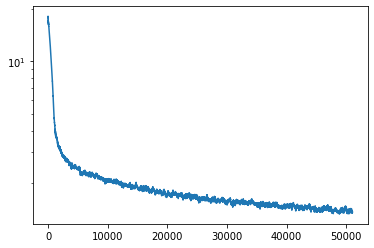

In [ ]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

### Now update the whole model, with embeddings and transformer layers.

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8
report_steps = 500 
epochs = 3
losses = []

Optimizing all parameters takes x1.5 longer than just embeddings (4h): about 6h per epoch. 

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))
    model.save_pretrained(save_model_path)
    tokenizer.save_pretrained(save_model_path)

EPOCH 0


  0%|          | 0/51019 [00:00<?, ?it/s]

step 0 loss 0.9673017263412476
step 500 loss 1.3375264348983764
step 1000 loss 1.3031280673742294
step 1500 loss 1.3155974283814431
step 2000 loss 1.285734974861145
step 2500 loss 1.3011595278382302
step 3000 loss 1.3006816270947457
step 3500 loss 1.2505051737427713
step 4000 loss 1.3009712474942208
step 4500 loss 1.2925726630687713
step 5000 loss 1.2850035366415977
step 5500 loss 1.264436600893736
step 6000 loss 1.2872441119253635
step 6500 loss 1.2501278729438783
step 7000 loss 1.2642870535254478
step 7500 loss 1.240564215362072
step 8000 loss 1.2564851052165031
step 8500 loss 1.2783652309775353
step 9000 loss 1.24153487059474
step 9500 loss 1.2436509608626365
step 10000 loss 1.227102575302124
step 10500 loss 1.2599322707355023
step 11000 loss 1.238300481557846
step 11500 loss 1.2608491314053536
step 12000 loss 1.2100392480790616
step 12500 loss 1.2164028249382972
step 13000 loss 1.2118090291619301
step 13500 loss 1.2452621747851371
step 14000 loss 1.2314736860394477
step 14500 loss 

  0%|          | 0/51019 [00:00<?, ?it/s]

step 0 loss 1.1324273806810379
step 500 loss 1.1153266297876834
step 1000 loss 1.1325898046791554
step 1500 loss 1.106544940650463
step 2000 loss 1.1147497542500495
step 2500 loss 1.1298377694189548
step 3000 loss 1.1145178884267808
step 3500 loss 1.0961512585282325
step 4000 loss 1.150789601624012
step 4500 loss 1.1315308120250702
step 5000 loss 1.1167441621422767
step 5500 loss 1.1110622864961623
step 6000 loss 1.1123104747235775
step 6500 loss 1.1145140364170074
step 7000 loss 1.1242117822766304
step 7500 loss 1.1240466977953911
step 8000 loss 1.0813867855072021
step 8500 loss 1.1279198758006095
step 9000 loss 1.1369470379352569
step 9500 loss 1.11920879727602
step 10000 loss 1.1199133202135563
step 10500 loss 1.1095662937164306
step 11000 loss 1.1178666979670524
step 11500 loss 1.098283593416214
step 12000 loss 1.0989602967500687
step 12500 loss 1.1399254206418992
step 13000 loss 1.120270090520382
step 13500 loss 1.0972463392317295
step 14000 loss 1.1136890835464002
step 14500 loss

  0%|          | 0/51019 [00:00<?, ?it/s]

step 0 loss 1.0779508466720582
step 500 loss 1.05649151968956
step 1000 loss 1.0408585014641285
step 1500 loss 1.0591072884202004
step 2000 loss 1.0483184240460395
step 2500 loss 1.0772425063848496
step 3000 loss 1.0143729958236218
step 3500 loss 1.0662302606105805
step 4000 loss 1.0444499458670615
step 4500 loss 1.0655460867881774
step 5000 loss 1.0373788571059703
step 5500 loss 1.0526831505298615
step 6000 loss 1.0369462184607983
step 6500 loss 1.0241054469943047
step 7000 loss 1.001981723546982
step 7500 loss 1.0342040237784387
step 8000 loss 1.0660586125850677
step 8500 loss 1.066643656015396
step 9000 loss 1.0529421593695878
step 9500 loss 1.0361130147278308
step 10000 loss 1.061078898191452
step 10500 loss 1.0543994237184524
step 11000 loss 1.0287830965518951
step 11500 loss 1.047242129802704
step 12000 loss 1.0291616313755512
step 12500 loss 1.0539074938893318
step 13000 loss 1.0521993960142135
step 13500 loss 1.0308318426907062
step 14000 loss 1.032182751774788
step 14500 loss 

The final loss was about 1.01.

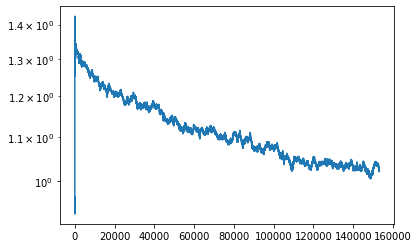

In [ ]:
pd.Series(losses).ewm(1000).mean().plot();
plt.yscale('log');

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/tokenizer_config.json',
 '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/special_tokens_map.json',
 '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/sentencepiece.bpe.model',
 '/gd/MyDrive/models/myv/mbart-large-51-ru-myv-v1/added_tokens.json')

In [ ]:
model.eval();

In [ ]:
myv, ru = random.choice(all_pairs)
myv, ru

('галань лапа', 'гусиная лапа')

In [ ]:
def translate(text, src='ru_RU', trg='myv_XX', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(ru)

'гузонь лапа'

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(myv))

{'input_ids': [269544, 95080, 49, 49467, 380, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

# Evaluate

In [ ]:
!ls /gd/MyDrive/datasets/nlp/myv_corpus/

dev1000.v1.json			     myv_mono.v1.json  train.v1.json
myv_mono.v1.back_translated.v1.json  test1000.v1.json


In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/dev1000.v1.json', 'r') as f:
    dev = json.load(f)

In [ ]:
dev_target = {k: [er for er, ru in v] for k, v in dev.items()}

In [ ]:
dev_translated = {k: [translate(ru) for er, ru in tqdm(v)] for k, v in dev.items()}

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
from sacrebleu import CHRF, BLEU
chrf_calc = CHRF(word_order=2)
bleu_calc = BLEU()

ChrF++ is 50, but BLEU is only 18. 

In [ ]:
for k in dev:
    s = chrf_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')
print(chrf_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                36.45
tales                37.33
constitution         61.46
games                29.37
fiction              25.51
wiki                 50.63
41.821449810361266


In [ ]:
for k in dev:
    s = bleu_calc.corpus_score(dev_translated[k], [dev_target[k]]).score
    print(f'{k:20s} {s:2.2f}')

print(bleu_calc.corpus_score(
    [t for k in dev_translated for t in dev_translated[k]], 
    [[t for k in dev_target for t in dev_target[k]]]
).score)

bible                9.37
tales                13.42
constitution         25.54
games                8.72
fiction              7.39
wiki                 30.55
18.728524159764728


In [ ]:
for k in dev:
    print(k)
    for i in range(3):
        print(dev[k][i][0])
        print(dev[k][i][1])
        print(dev_translated[k][i])
        print()

bible
Давид инязороськак корты: «Кадык сынь понгить кундамкас каванямо шкастост! Кадык сынь прыть туворс, ды кадык сы тенст чумонь пандома!
И Давид говорит: да будет трапеза их сетью, тенетами и петлею в возмездие им;
Ды Давид мерсь: «Кадык сынст каванямост кармить улеме сеть, конат тенетне ды петлюсть тенст пандомакс.

Сюкпря Пазонтень, кие кирвазтизе Титэнь седейс тынк кисэ секе жо бажамонть, кона палы минек седейсэяк!
Благодарение Богу, вложившему в сердце Титово такое усердие к вам.
Сюкпря Пазонтень, кона путсь Титовонь седейсэ истямо покш мель тыненк.

Ансяк бути мон карман одс стявтомо сень, мезенть калавтыя икеле, сестэ теньсэ невтьса: мон – Коень каладыця.
Ибо если я снова созидаю, что разрушил, то сам себя делаю преступником.
Бути мон таго теинь сень, мезенть калавтан, сестэ эсь прят теян зыянонь теицякс.

tales
Вана мезе ёвтнить миненек рузонь атятне: зярдо велесь тесэ арасель, се латксонть эрясть розбойникть, эрясть землянкасо.
И вот что рассказывают наши русские старики: «К

# Translate the monolingual corpus for back-translation

**todo: collect a russian monolingual corpus**

In [ ]:
def translate_batch(texts, src='ru_RU', trg='myv_XX', max_length='auto', num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
    if max_length == 'auto':
        max_length = int(10 + encoded.input_ids.shape[1] * 1.5)
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


In [ ]:
translate_batch(all_sentences[:4])

['Приветствую тебя, Хоразин! Приветствую тебя, Бетсаида! Если бы народ Тирский и Сидонский видел чудеса, которые явились вам, то они уже давно одевались в одежду скорби и не сидели бы над кулупами.',
 'Здесь работающих — эти естественные условия, сбор съедобных грибов.',
 'Включает в себя Адамсон Генрих, где открылся Музей чисел Койдула.',
 'Сплыть, девочки!']

In [ ]:
batch_size = 16

In [ ]:
all_translated = []

[]

In [ ]:
cleanup()


for i in trange(0, len(all_sentences), batch_size):
    batch = all_sentences[i: i + batch_size]
    if all_translated[i: i + batch_size]:
        continue
    try:
        all_translated.extend(translate_batch(batch))
    except RuntimeError:
        print('error at', i)
        cleanup()
        bb = []
        for b in batch:
            try:
                bb.append(translate_batch([b])[0])
            except RuntimeError:
                print('mega error!')
                bb.append(b)
                cleanup()
        all_translated.extend(bb)

    if i and (i // batch_size) % 100 == 0:
        with open('/gd/MyDrive/datasets/nlp/myv_corpus/rus_mono.v1.back_translated.v1.json', 'w') as f:
            json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)
        print(i, 'saving...')

  0%|          | 0/20854 [00:00<?, ?it/s]

40000 saving...
41600 saving...
43200 saving...
44800 saving...
46400 saving...
48000 saving...
49600 saving...
51200 saving...
52800 saving...
54400 saving...
56000 saving...
57600 saving...
59200 saving...
60800 saving...
62400 saving...
64000 saving...
65600 saving...
67200 saving...
68800 saving...
70400 saving...
72000 saving...
73600 saving...
75200 saving...
76800 saving...
78400 saving...
80000 saving...
81600 saving...
83200 saving...
84800 saving...
86400 saving...
88000 saving...
89600 saving...
91200 saving...
92800 saving...
94400 saving...
96000 saving...
97600 saving...
99200 saving...
100800 saving...
102400 saving...
104000 saving...
105600 saving...
107200 saving...
108800 saving...
110400 saving...
112000 saving...
113600 saving...
115200 saving...
116800 saving...
118400 saving...
120000 saving...
121600 saving...
123200 saving...
124800 saving...
126400 saving...
128000 saving...
129600 saving...
131200 saving...
132800 saving...
134400 saving...
136000 saving...
1

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/rus_mono.v1.back_translated.v1.json', 'w') as f:
    json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)